In [210]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import pandas as pd
from networkx.drawing.nx_agraph import graphviz_layout
from icecream import ic


In [130]:
# load the dataframe 
title_number = "12"
# df = pd.read_csv(f"../dataframe/{title_number}.csv")
df = pd.read_parquet(f"../dataframe/{title_number}.parquet")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117306 entries, 0 to 117305
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   p_id          117306 non-null  object
 1   text          117306 non-null  object
 2   child_ids     117306 non-null  object
 3   cfr_links     117306 non-null  object
 4   other_links   117306 non-null  object
 5   link_targets  117306 non-null  object
dtypes: object(6)
memory usage: 5.4+ MB


In [131]:
# first let's do a sample
df_sample = df.sample(10)
df_sample.head()

,p_id,text,child_ids,cfr_links,other_links,link_targets
22542,215.1(b),(b)Purpose and scope.,"[215.1(b)(1), 215.1(b)(2), 215.1(b)(3), 215.1(...",[],"[https://www.govinfo.gov/link/uscode/12/1817, ...",[]
101641,1041.8(b)(1),(1)General.A lender must not initiate a paymen...,[],[/on/2023-09-28/title-12/section-1041.8#p-1041...,[],[1041.8(b)]
116806,1808.305(c)(3),(3)No Bond Loan proceeds may be disbursed late...,[],[],[],[]
58492,337.3(c)(2),(2)An FDIC-supervised institution is authorize...,"[337.3(c)(2)(i), 337.3(c)(2)(ii), 337.3(c)(2)(...",[/on/2023-09-28/title-12/section-215.5#p-215.5...,[],"[215.5(c)(1), 215.5(c)(2), 215.5(c)(1), 215.5(..."
3285,3.701(e)(4),(4)Limited life preferred stockmeans preferred...,[],[],[],[]


In [109]:
# [(a,b) for a in [1] for b in [1,2,3]]



row
p-Supplement-I-to-Part-1026 []
row
p-701.22(b)(5)(ii) []
row
p-1208.2(Disposable%20pay)(1) []
row
p-1022.130(j) []
row
p-347.215(b) ['p-347.215(a)']
row
p-1022.54(c)(1) []
row
p-31.3(c)(1) []
row
p-1041.8(c)(1) ['p-1041.8(b)', 'p-1041.8(c)', 'p-1041.8(d)']
row
1271.19 []
row
31.1 []


In [143]:
# Create a new directed graph
G_sample = nx.DiGraph()

for row in df_sample.itertuples():
    edges = [(row.p_id, target) for target in row.link_targets if target != []]
    children = [(row.p_id, child) for child in row.child_ids if child != []]
    G_sample.add_edges_from(edges)
    G_sample.add_edges_from(children)

In [267]:
# Define some drawing functions
def draw_simple(G,w=10,h=10):
    plt.figure(figsize=(w,h))
    pos = nx.spring_layout(G, seed=7, k=0.5, iterations=50)
    nx.draw(G, pos, with_labels=True, node_color='none', node_size=1000, edge_color='gray', linewidths=1, font_size=10)
    plt.show()

def draw_tree(G,w=10,h=10):
    plt.figure(figsize=(w,h))
    pos = graphviz_layout(G, prog='dot', args='-Goverlap=compress -Gsep=4')
    nx.draw(G, pos, with_labels=True, node_color='none', node_size=1000, edge_color='gray', linewidths=1, font_size=10)
    plt.show()

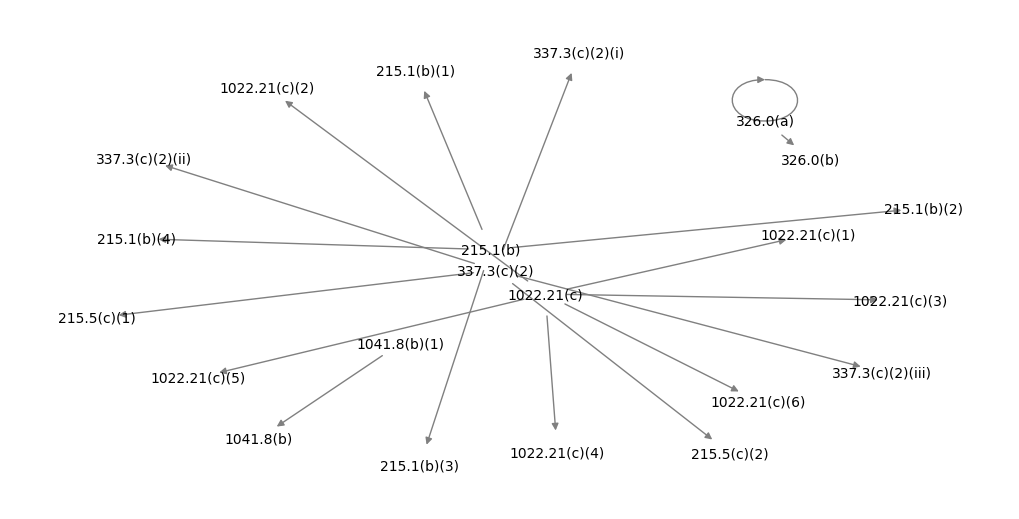

In [148]:
draw_simple(G_sample,10,5)

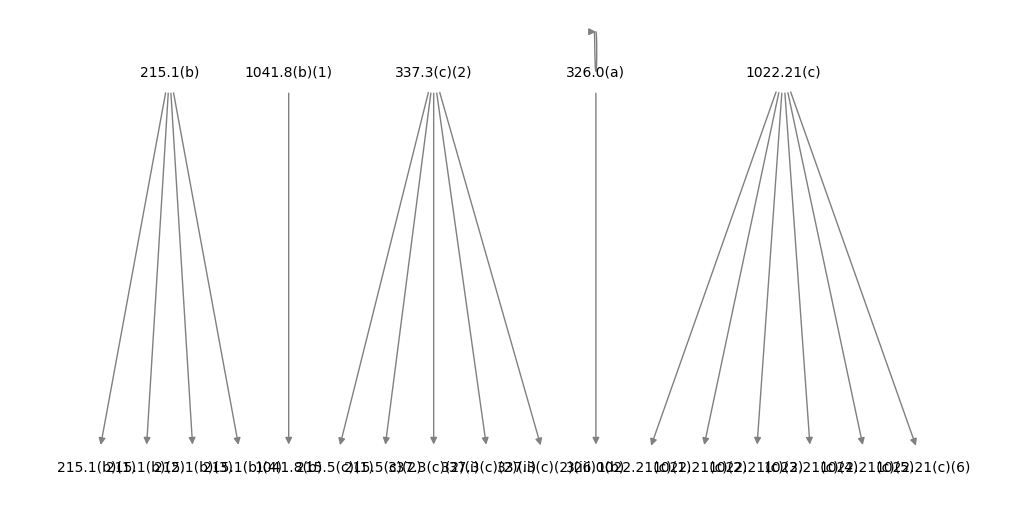

In [268]:
draw_tree(G_sample, 10, 5)

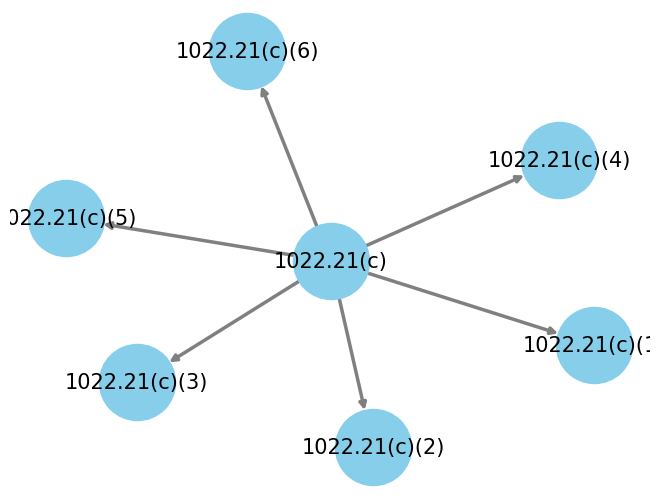

In [278]:
all_nodes = list(G_sample.nodes())
node_of_interest = random.choice(all_nodes)

# Extract the relevant nodes and edges around the random paragraph
ancestors = nx.ancestors(G_sample, node_of_interest)
descendants = nx.descendants(G_sample, node_of_interest)

# Combine the sets and add the original node
nodes_set = ancestors.union(descendants)
nodes_set.add(node_of_interest)

# Create subgraph
subgraph = G_sample.subgraph(nodes_set)

# Visualize the subgraph
pos = nx.spring_layout(subgraph, k=0.5)  # Adjust 'k' as necessary to spread out nodes
nx.draw(subgraph, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=15, width=2.5, edge_color='gray')
plt.show()

In [193]:
# now for the whole kahuna
G = nx.DiGraph()

for row in df.itertuples():
    edges = [(row.p_id, target) for target in row.link_targets if target != []]
    children = [(row.p_id, child) for child in row.child_ids if child != []]
    G.add_edges_from(edges)
    G.add_edges_from(children)

In [194]:
#some stats
print(f"Number of nodes: {G.number_of_nodes():,}")
print(f"Number of edges: {G.number_of_edges():,}")
print(f"Average degree: {(2 * G.number_of_edges()) / G.number_of_nodes():.2f}")
print(f"Density: {nx.density(G):.2f}")


Number of nodes: 124,757
Number of edges: 436,995
Average degree: 7.01
Density: 0.00


In [279]:
# let's make a subgraph of title 1.

include = '1.'
view = nx.Graph()
for u, v in G.edges():
    if u.startswith(i) or v.startswith(i):
        view.add_edge(u, v)
        
# ic(list(view.nodes()))
# ic(list(view.edges()))
print(f"Number of nodes in subgraph: {view.number_of_nodes():,}")


Number of nodes in subgraph: 187


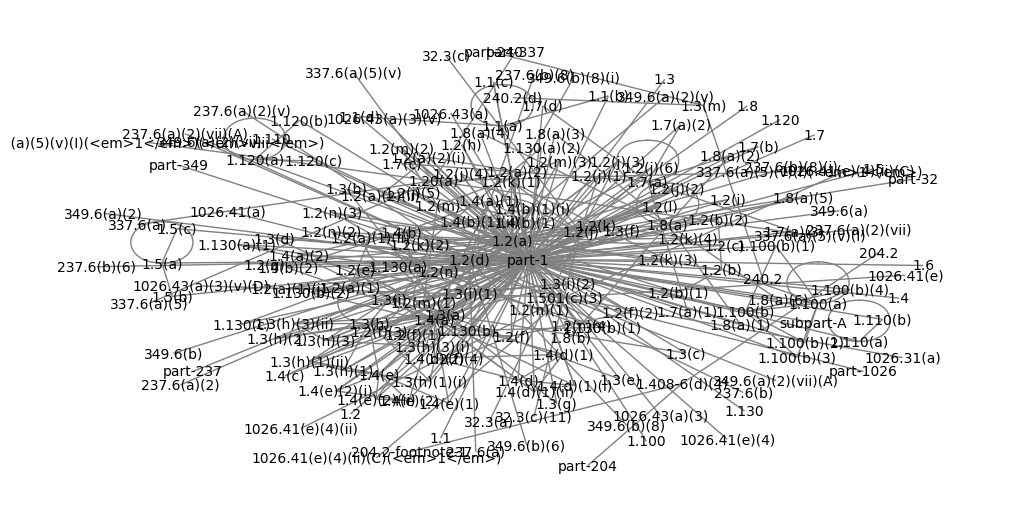

In [280]:
draw_simple(view, 10, 5)

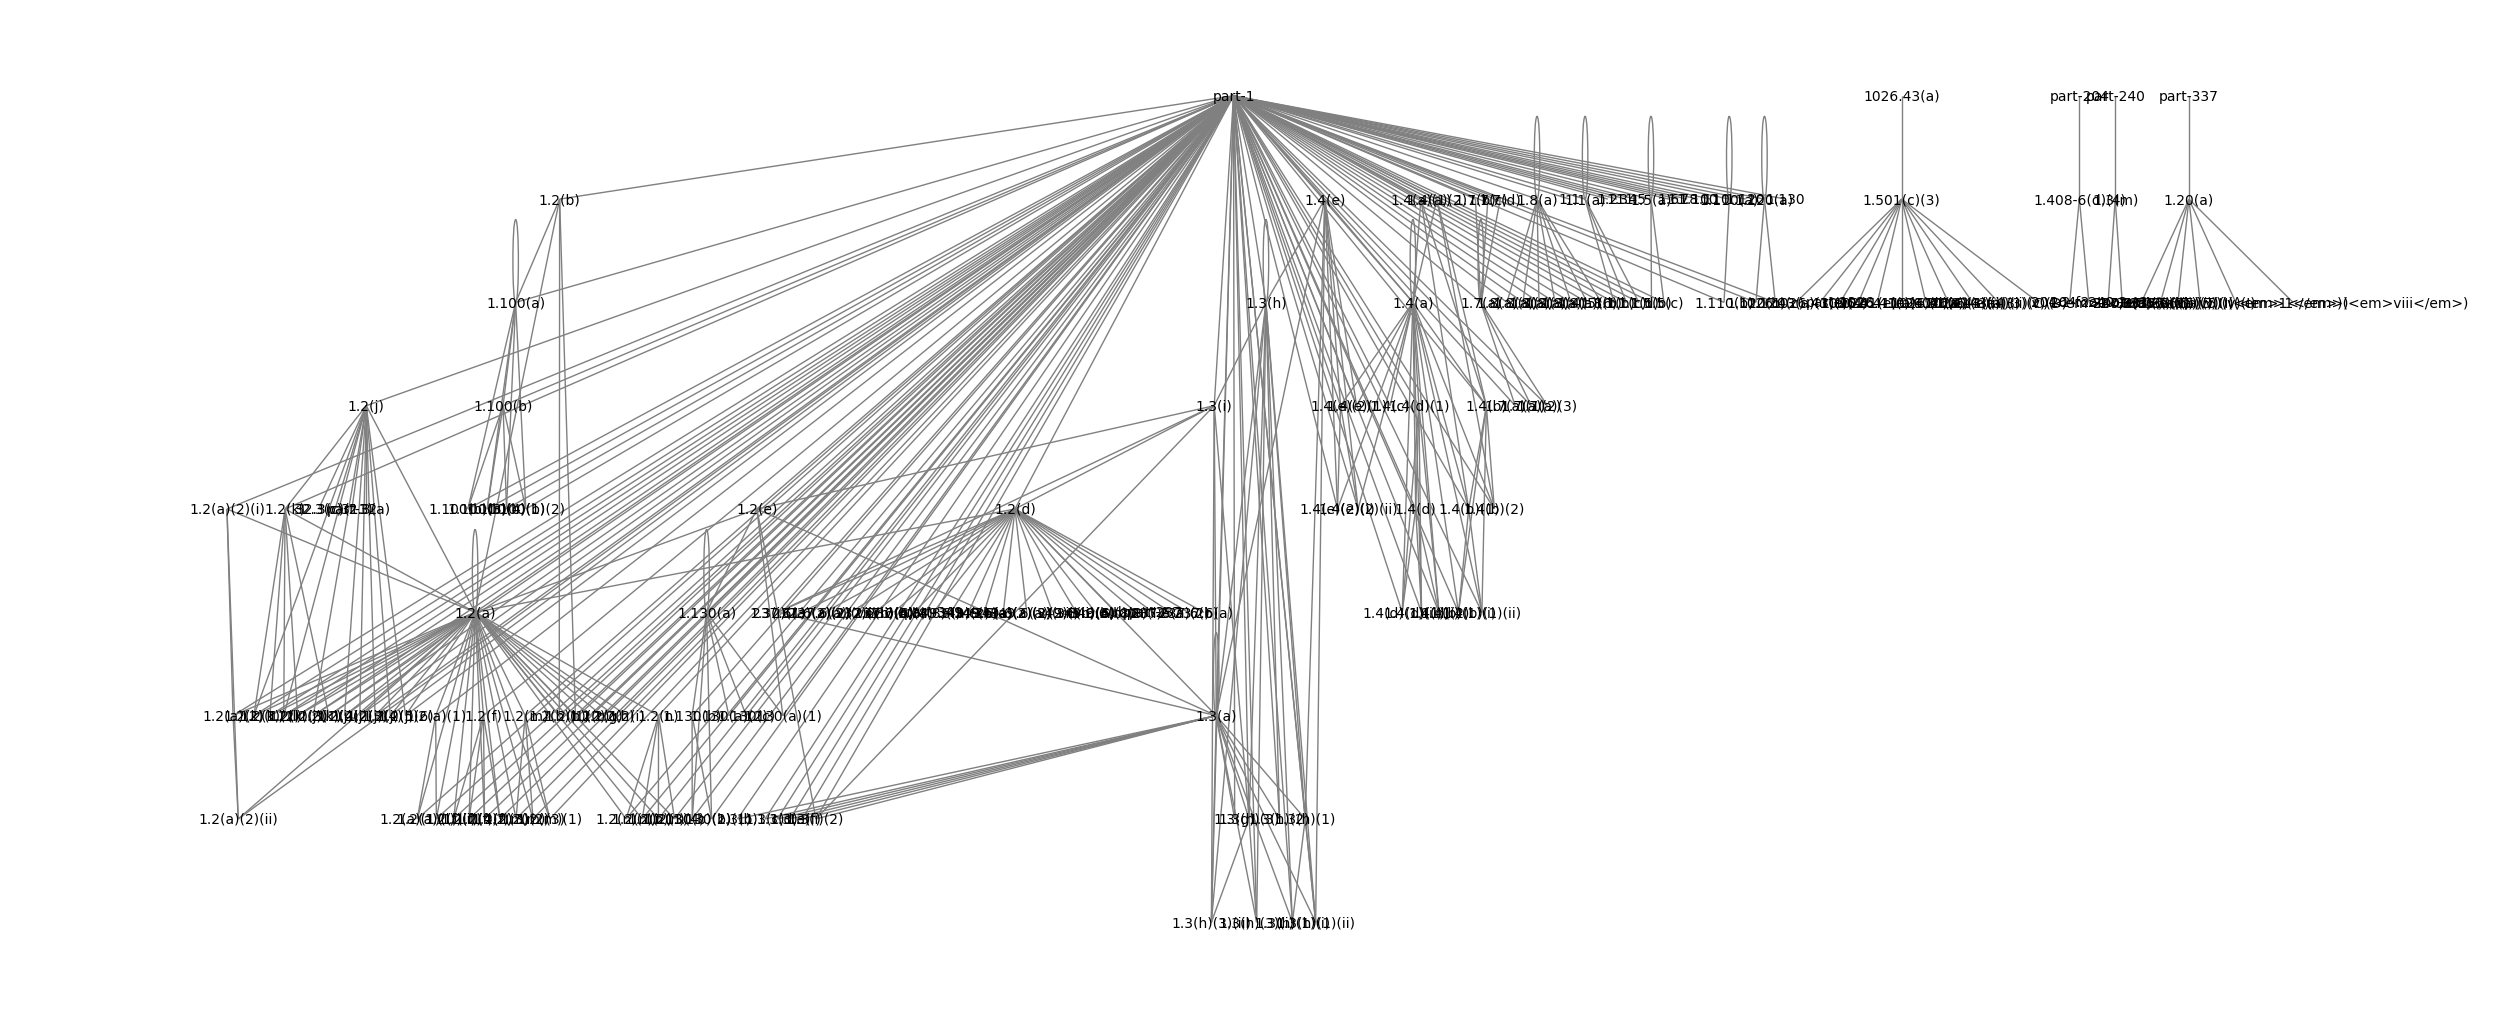

In [282]:
draw_tree(view, 25, 10)

In [162]:
nodes_with_external = df[df['other_links'].astype(bool)]
nodes_with_external['other_links']

ValueError: setting an array element with a sequence.